In [19]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torch.optim as optim
from torch.optim import lr_scheduler


from torchvision import transforms, utils, models
from torchvision.transforms import Resize, ToTensor, Normalize

import matplotlib.pyplot as plt
import time
import copy
from datetime import datetime
import wandb

In [2]:
train_path = '/opt/ml/pang/solid_waste/train.csv'
dataset = pd.read_csv(train_path)
dataset.columns = ['id','path','class']
dataset

,id,path,class
0,0,/opt/ml/pang/solid_waste/new/plastic/plastic67...,0
1,1,/opt/ml/pang/solid_waste/new/plastic/plastic16...,0
2,2,/opt/ml/pang/solid_waste/new/plastic/plastic73...,0
3,3,/opt/ml/pang/solid_waste/new/plastic/plastic62...,0
4,4,/opt/ml/pang/solid_waste/new/plastic/plastic35...,0
...,...,...,...
7198,2419,/opt/ml/pang/solid_waste/black/metal/1 (204).jpg,2
7199,2420,/opt/ml/pang/solid_waste/black/metal/1 (52).jpg,2
7200,2421,/opt/ml/pang/solid_waste/black/metal/1 (49).jpg,2
7201,2422,/opt/ml/pang/solid_waste/black/metal/1 (65).jpg,2


In [3]:
class TrashDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_frame, transform=None):
        '''
        arg:
            class_idx
            transform
        '''
        self.data_frame = data_frame
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_frame.iloc[idx,-2])
        image = Image.open(img_path)
        label = self.data_frame.iloc[idx, -1]
        
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
#     def set_transform(self, transform):
#         """
#         transform 함수를 설정하는 함수입니다.
#         """
#         self.transform = transform

In [4]:
data_transforms = {
    'train'  : transforms.Compose([
        transforms.CenterCrop(380),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.CenterCrop(340),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
trash_dataset = TrashDataset(dataset, data_transforms['train'])
trash_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


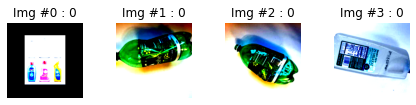

In [6]:
fig = plt.figure()

for i in range(len(trash_dataset)):
    img, label = trash_dataset[i]
    
    print(i, img.shape, label)
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title(f'Img #{i} : {label}')
    ax.axis('off')
    plt.imshow(utils.make_grid(img, nrow=5).permute(1,2,0))
    
    if i == 3:
        break

In [7]:
len(trash_dataset)

7203

In [8]:
VALIDATION_RATIO = 0.10
BATCH_SIZE = 32


In [9]:
valid = int(VALIDATION_RATIO) * len(trash_dataset)
train_dataset, valid_dataset = random_split(trash_dataset,[len(trash_dataset) - valid,valid])
            

In [10]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=True
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=32,
    num_workers=4,
    shuffle=False
)

# Model 정의(VGGNet-11)

In [11]:
model = models.mnasnet1_0(pretrained=True)
model.fc = nn.Linear(in_features=1000, out_features=3)

In [12]:
model

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

# Train

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = VGG11Classification(num_classes=18)
# model = model_EfficientNet
print(device)
model.to(device)
LEARNING_RATE = 3e-5

criterion = nn.CrossEntropyLoss()
update_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(update_params, lr=LEARNING_RATE)

cuda:0


In [20]:
def train_one_epoch(epoch):
    print("\n Epoch: %d" % epoch)
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
#         targets = torch.Tensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 30 == 0:
            print('Loss: %.3f | Acc: %.3f%% ' %(train_loss/(batch_idx+1),100.*correct/total))
            wandb.log({"loss": loss})

    return (100.*correct/total)

In [21]:
def test_one_epoch(epoch):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f'Accuracy of the network on the {total} test images: %d %%' % (
    100 * correct / total))

In [22]:
def save_model(epoch, name, save_path):
    print('saved model {}'.format(save_path)) 
    if not os.path.exists(save_path):
        os.mkdirs(save_path)
    file_name = '{}_{}_{}.pth'.format(datetime.now() ,name, epoch)
    file_path = os.path.join(save_path, file_name)
    torch.save(model.state_dict(), file_path)

    return None

In [23]:
def train_eval():
    print("training start!\n")
    best = 0.0
    for epoch in range(20):
        chk = train_one_epoch(epoch)
#         test_one_epoch(epoch)
        if chk > best:
            save_model(epoch,'mnasnet','/opt/ml/pang/model')
            best = chk

In [ ]:
wandb.init(project="trash", reinit=True)
wandb.run.name = 'mnasnet'
wandb.config.update({"epochs": 20, "batch_size": 32})

train_eval()

wandb: Currently logged in as: hwan1753 (use `wandb login --relogin` to force relogin)


training start!


 Epoch: 0
Loss: 11.416 | Acc: 0.000% 
Loss: 10.688 | Acc: 0.000% 
Loss: 9.669 | Acc: 0.359% 
Loss: 8.632 | Acc: 2.060% 
Loss: 7.616 | Acc: 7.851% 
Loss: 6.728 | Acc: 15.542% 
Loss: 5.935 | Acc: 23.809% 
Loss: 5.283 | Acc: 31.161% 
saved model /opt/ml/pang/model

 Epoch: 1
Loss: 1.041 | Acc: 84.375% 
Loss: 0.914 | Acc: 83.669% 
Loss: 0.806 | Acc: 85.143% 
Loss: 0.750 | Acc: 85.749% 
Loss: 0.688 | Acc: 86.674% 
Loss: 0.649 | Acc: 87.417% 
Loss: 0.606 | Acc: 88.018% 
Loss: 0.581 | Acc: 88.226% 
saved model /opt/ml/pang/model

 Epoch: 2
Loss: 0.413 | Acc: 90.625% 
Loss: 0.308 | Acc: 93.044% 
Loss: 0.297 | Acc: 93.084% 
Loss: 0.297 | Acc: 92.857% 
Loss: 0.292 | Acc: 92.588% 
Loss: 0.287 | Acc: 92.695% 
Loss: 0.285 | Acc: 92.869% 
Loss: 0.277 | Acc: 93.069% 
saved model /opt/ml/pang/model

 Epoch: 3
Loss: 0.222 | Acc: 93.750% 
Loss: 0.162 | Acc: 95.565% 
Loss: 0.154 | Acc: 95.594% 
Loss: 0.150 | Acc: 95.742% 
Loss: 0.159 | Acc: 95.532% 
Loss: 0.168 | Acc: 95.323% 
Loss: 0.1